# Guardians of the Memory - Modeling - Felix

1. Preprocessing and feature engineering
2. Modeling
    * 2.1. Defining functions
    * 2.2. XGBoost Classifier
    * 2.3. GaussianNB
    * 2.4. Isolation Forest
    * 2.5. XGBoost Regressor
3. Error Analysis

Import Libraries

In [1]:
import warnings # Turn off warnings
warnings.filterwarnings('ignore')

import os # Import own functions
import sys
sys.path.append("..") # Fix folder structure
from src.data.preprocessing import load_preprocess_data, train_test_splitter, calculate_target, drop_normalized_cols
from src.features.feature_engineering import unwrap_smart_7, ts_ema, calculate_smart_999, create_features

import pandas as pd # Pandas and Numpy
import numpy as np

import mlflow # MLFlow for experiment tracking
EXPERIMENT_NAME = "guardians_of_the_memory_felix"
TRACKING_URI = open("../.mlflow_uri").read().strip()

import seaborn as sns # Plotting libraries
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# Sklearn for preprocessing and modeling
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import IsolationForest, RandomForestClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier, XGBRegressor, cv
from sklearn.naive_bayes import GaussianNB

# Sklearn metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, recall_score, fbeta_score
from sklearn.metrics import make_scorer, precision_recall_curve, mean_squared_error

RSEED = 42 # Random seed for repeatability

## 1. Preprocessing and feature engineering

Load the data

In [2]:
repo_path = os.getcwd()+"/../" # Path to the parent directory
df = load_preprocess_data(path=repo_path) # Load data and preprocessing
df_backup = df.copy()
print("Initial shape:", df.shape)

Initial shape: (462966, 42)


Create features

In [3]:
df = create_features(df, interval=30, trigger_percentage=0.05)
print("Shape after feature engineering", df.shape)

100%|██████████| 608/608 [00:37<00:00, 16.34it/s]


Shape after feature engineering (462966, 64)


In [4]:
def get_smart_999_accumulated(df_in):
    df_tmp = df_in.copy()
    serials = df_tmp['serial_number'].unique()
    #serials = serials[0:2]
    #print(serials)
    for i, serial in enumerate(serials):
        df_serial = df_tmp.query('serial_number == @serial').sort_values(by='date').reset_index(drop=True)
        df_serial['smart_999_accumulated'] = df_serial['smart_999'].cumsum()
        if i == 0:
            df = df_serial.copy()
        else:
            df = pd.concat([df, df_serial], ignore_index=True)
    return df

In [7]:
df = get_smart_999_accumulated(df)

Dropping observations and columns
- Not enough drives over 800 days before failure
- Outliers in smart_7_raw

In [8]:
# Remove countdowns over 800
df = df[df.countdown <= 800]
print("Shape after removal of large countdowns:", df.shape)

# Remove smart_7_raw outliers
sn_to_drop = df[df.smart_7_raw > 5e10].serial_number.unique()
for sn in sn_to_drop:
    df.drop(df[df.serial_number == sn].index, inplace=True)
print("Shape after removal of smart_7_raw outlier:", df.shape)

Shape after removal of large countdowns: (418172, 65)
Shape after removal of smart_7_raw outlier: (416073, 65)


## 2. Modeling

### 2.1. Defining functions

In [9]:
def create_train_data(df, feats, days=30, test_size=0.3, random_state=42):
        """Select features, create target and train-test-split

        Args:
            df (_type_): _description_
            feats (_type_): Features to include
            days (int, optional): Time window for target calculation. Defaults to 30.
            test_size (float, optional): Size for train-test-split. Defaults to 0.3.
            random_state (_type_, optional): Random seed. Defaults to 42.

        Returns:
            _type_: Split features and target
        """
        print("Splitting test and train data")
        X = df[feats]
        y = calculate_target(df, days=days)

        X_train, X_test, y_train, y_test = train_test_splitter(X,y,test_size=0.3,random_state=RSEED)
        X_train = X_train.drop(["serial_number"], axis=1)
        X_test = X_test.drop(["serial_number"], axis=1)
        print(f"Balance of split: {(y_train.sum()/len(y_train))/(y_test.sum()/len(y_test)):.2f}")
        print("Shape of the train dataset:", X_train.shape)
        print("Shape of the test dataset:", X_test.shape)
        print("---------------------------------------------------")
        return X_train, X_test, y_train, y_test

def normalize_data(X_train, X_test, minmax=True):
        """Scale train and test data

        Args:
            X_train (_type_): X_train
            X_test (_type_): X_test
            minmax (bool, optional): Use minmaxscaling or standard scaling. Defaults to True.

        Returns:
            _type_: Scaled train and test data
        """
        print("Scaling data")
        print("---------------------------------------------------")
        if minmax:
                scaler = StandardScaler()
        else:
                scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        return X_train, X_test

def log_transform(X_train, X_test):
        """Log transform all features

        Args:
            X_train (_type_): X_train
            X_test (_type_): X_test

        Returns:
            _type_: Transformed data
        """
        print("Log transform features")
        print("---------------------------------------------------")
        return np.log(X_train), np.log(X_test)

def train_eval_model(model, X_train, X_test, y_train, y_test):
        """Train the model, make predictions and evaluate the model

        Args:
            model (_type_): Model including hyperparameters
            X_train (_type_): X_train
            X_test (_type_): X_test
            y_train (_type_): y_train
            y_test (_type_): y_test

        Returns:
            _type_: Fitted model, predictions and probabilities
        """
        print("Fitting")
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_pred = model.predict(X_test)
        y_train_proba = model.predict_proba(X_train)
        y_proba = model.predict_proba(X_test)
        fbeta_test = fbeta_score(y_test, y_pred, beta=2).round(2)
        auc_test = roc_auc_score(y_test, y_proba[:,1]).round(2)
        recall_test = recall_score(y_test, y_pred).round(2)
        fbeta_train = fbeta_score(y_train, y_train_pred, beta=2).round(2)
        auc_train = roc_auc_score(y_train, y_train_proba[:,1]).round(2)
        recall_train = recall_score(y_train, y_train_pred).round(2)
        print("---------------------------------------------------")
        print("Model evaluation")
        print("F2 score test (train):", fbeta_test, "(", fbeta_train, ")")
        print("Area under the ROC curve test (train):", auc_test, "(", auc_train, ")")
        print("Recall test (train):", recall_test, "(", recall_train, ")")
        return model, y_pred, y_proba[:,1]

def plot_pr_curve(y_test, y_pred_proba):
        """Plot the precision recall curve and the f2 curve

        Args:
            y_test (_type_): Predictions
            y_pred_proba (_type_): Predicted probabilities

        Returns:
            _type_: F2 scores and the threshold of maximum F2
        """

        pre, rec, thresholds1 = precision_recall_curve(y_test, y_pred_proba)
        f2 = (5)*(pre*rec)/(4*pre + rec)
        plt.plot(thresholds1, pre[1:],'r-',label = 'Precision Model')
        plt.plot(thresholds1, rec[1:],'b-',label = 'Recall Model')
        plt.plot(thresholds1, f2[1:],'g-',label = 'f2 Model')
        plt.legend()
        plt.xlabel('Threshold')
        plt.ylabel('Metrics')
        plt.show()
        idx = np.nanargmax(f2)
        return f2, thresholds1[idx]

def predict_threshold(y_pred_proba, threshold=0.5):
        """Make predictions based on a threshold

        Args:
            y_pred_proba (_type_): Predicted probabilities
            threshold (float, optional): Threshold. Defaults to 0.5.

        Returns:
            _type_: _description_
        """
        return y_pred_proba > threshold

def eval_model(y_true, y_pred, y_proba):
        """Calculate the scores of the model

        Args:
            y_true (_type_): True labels
            y_pred (_type_): Predicted labels
            y_proba (_type_): Predicted probabilities
        """
        fbeta_test = fbeta_score(y_true, y_pred, beta=2).round(2)
        auc_test = roc_auc_score(y_true, y_proba).round(2)
        recall_test = recall_score(y_true, y_pred).round(2)
        print("F2 score test:", fbeta_test)
        print("Area under the ROC curve test:", auc_test)
        print("Recall test:", recall_test)
        return

Scorer for XGBoost and for sklearn gridsearch

In [10]:
def xgb_scorer(predt, dtrain, threshold=0.5):
    y = dtrain > threshold
    #predt = (predt > threshold)
    return fbeta_score(y, predt, beta=2)

def xgb_scorer_old(predt, dtrain, threshold=0.5):
    dtrain= dtrain.get_label()
    pre, rec, thresholds1 = precision_recall_curve(dtrain, predt)
    f2 = (5)*(pre*rec)/(4*pre + rec)
    idx = np.nanargmax(f2)
    predt = (predt > thresholds1[idx])
    return "xgb_scorer", fbeta_score(dtrain, predt, beta=2)

#ftwo_scorer = make_scorer(fbeta_score, beta=2)

def fbeta_adj(y_true, y_proba, beta=2):
    pre, rec, thresholds1 = precision_recall_curve(y_true, y_proba)
    f2 = (5)*(pre*rec)/(4*pre + rec)
    idx = np.nanargmax(f2)
    y_pred = (y_proba > thresholds1[idx])
    print(y_proba)
    return fbeta_score(y_true, y_pred, beta=beta)

ftwo_scorer = make_scorer(fbeta_adj, beta=2, needs_proba=True)

### 2.2 XGBOOST Classification

Splitting test and train data
Balance of split: 1.02
Shape of the train dataset: (289986, 21)
Shape of the test dataset: (126087, 21)
---------------------------------------------------
Fitting
---------------------------------------------------
Model evaluation
F2 score test (train): 0.37 ( 0.66 )
Area under the ROC curve test (train): 0.82 ( 0.98 )
Recall test (train): 0.66 ( 0.96 )


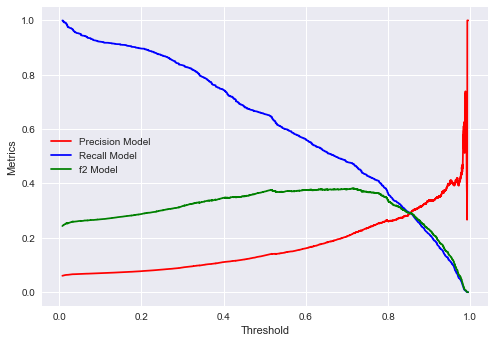

In [9]:
# Select features to include in the modeling
feats = ['smart_4_raw', 'smart_5_raw', 'smart_7_mod', 'smart_9_raw',
       'smart_12_raw', 'smart_183_raw', 'smart_184_raw', 'smart_187_raw',
       'smart_188_raw', 'smart_189_raw', 'smart_190_raw', 'smart_192_raw',
       'smart_193_raw', 'smart_194_raw', 'smart_197_raw', 'smart_198_raw',
       'smart_199_raw', 'smart_240_raw', 'smart_241_raw', 'smart_242_raw',
       'smart_999',
       'serial_number']
# Generate train and test data
X_train, X_test, y_train, y_test = create_train_data(df, feats, days=30, test_size=0.3, random_state=RSEED)
# Transform the data
# X_train, X_test = log_transform(X_train+1, X_test+1)
# X_train, X_test = normalize_data(X_train, X_test)
# Define the model
model = XGBClassifier(  eval_metric=xgb_scorer, # Evaluation metric, can use our xgb_scorer
                        disable_default_eval_metric=True,
                        scale_pos_weight=len(y_train)/y_train.sum(), # ratio of number of negative class to the positive class
                        colsample_bytree=0.4, # 1, Number of features used by tree, lower to regularize
                        subsample=0.3, # 1, ratio of the training instances used, lower to regularize
                        eta=0.1, # 0.3, learning rate, lower values to regularize
                        gamma=0.2, # 0, regularization parameter, higher to regularize
                        max_depth=6, # 6, maximum tree depth
                        #n_estimators= , #
                        min_child_weight=1 , # 1, minimum sum of instance weight needed in a leaf, higher to regularize
                        #lambda=1, # L2 regularization
                        #alpha=0, # L1 regularization
                        #early_stopping_rounds = 100
                        use_label_encoder=False, verbosity=0,
                        )
# Fit and evaluate the model
model, y_pred, y_proba = train_eval_model(model, X_train, X_test, y_train, y_test)
_, threshold = plot_pr_curve(y_test, y_proba)

In [40]:
y_pred_t = predict_threshold(y_proba, threshold)
eval_model(y_true=y_test, y_pred=y_pred_t, y_proba=y_proba)

F2 score test: 0.38
Area under the ROC curve test: 0.82
Recall test: 0.47


### 2.2.1 Additional plots

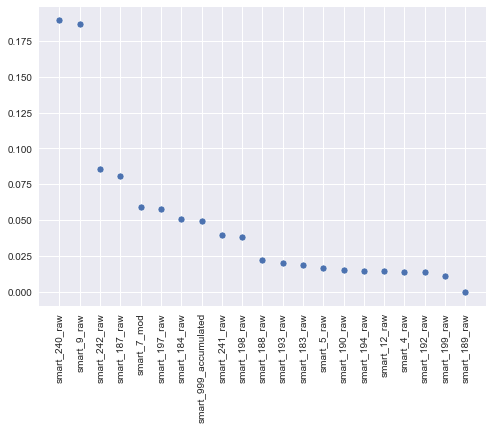

In [106]:
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
sns.scatterplot(data=feat_importances)
plt.xticks(rotation=90);

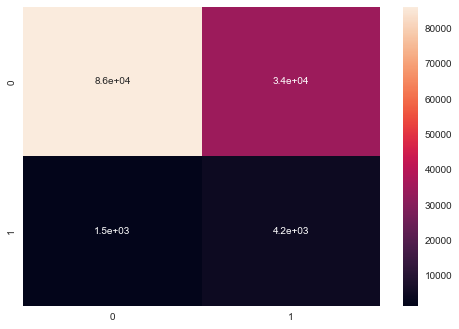

In [82]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True);

### 2.2.2 CV

[Nice manual I followed](http://ethen8181.github.io/machine-learning/trees/xgboost.html)

Splitting test and train data
Balance of split: 1.02
Shape of the train dataset: (289986, 22)
Shape of the test dataset: (126087, 22)
---------------------------------------------------
Log transform features
---------------------------------------------------
Scaling data
---------------------------------------------------
F2 score test: 0.36
Area under the ROC curve test: 0.83
Recall test: 0.74


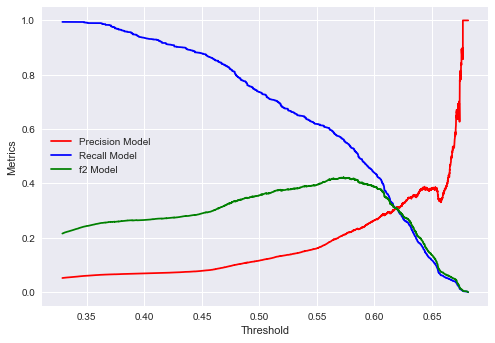

F2 score test: 0.42
Area under the ROC curve test: 0.83
Recall test: 0.56


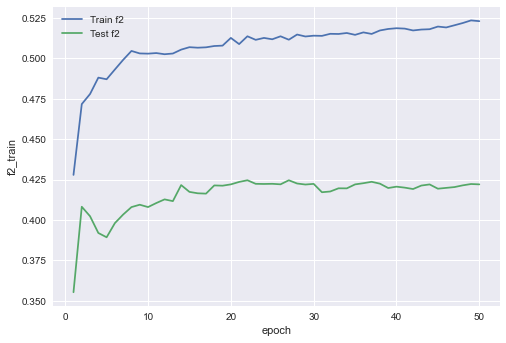

In [26]:
# Select features to include in the modeling
feats = ['smart_4_raw', 'smart_5_raw', 'smart_7_mod', 'smart_9_raw',
       'smart_12_raw', 'smart_183_raw', 'smart_184_raw', 'smart_187_raw',
       'smart_188_raw', 'smart_189_raw', 'smart_190_raw', 'smart_192_raw',
       'smart_193_raw', 'smart_194_raw', 'smart_197_raw', 'smart_198_raw',
       'smart_199_raw', 'smart_240_raw', 'smart_241_raw', 'smart_242_raw',
       'smart_999_accumulated', 'smart_999',
       'serial_number']
# Generate train and test data
X_train, X_test, y_train, y_test = create_train_data(df, feats, days=30, test_size=0.3, random_state=RSEED)
# Transform the data
X_train, X_test = log_transform(X_train+1, X_test+1)
X_train, X_test = normalize_data(X_train, X_test)
# Evaluation set to use for cv
eval_s = [(X_train, y_train.values), (X_test, y_test.values)]
# Define the model
model = XGBClassifier(  disable_default_eval_metric=True,
                        validate_parameters=True,
                        objective="binary:logistic",
                        #eval_metric=xgb_scorer, # Evaluation metric, can use our xgb_scorer
                        scale_pos_weight=len(y_train)/y_train.sum(), # ratio of number of negative class to the positive class
                        colsample_bytree=0.4, # 1, Number of features used by tree, lower to regularize
                        subsample=0.3, # 1, ratio of the training instances used, lower to regularize
                        eta=0.01, # 0.3, learning rate, lower values to regularize
                        gamma=1, # 0, regularization parameter, higher to regularize
                        max_depth=6, # 6, maximum tree depth
                        n_estimators=50 , # 100, number of trees to grow
                        min_child_weight=2 , # 1, minimum sum of instance weight needed in a leaf, higher to regularize
                        reg_lambda=0.7, # 1, L2 regularization
                        reg_alpha=1, # 0, L1 regularization
                        #early_stopping_rounds = 5, #100
                        use_label_encoder=False,
                        )
#model.set_params(eval_metric=xgb_scorer_old, eval_set=eval_s)
# Fit and evaluate the model
evals_result = {}
model.fit(X_train, y_train, eval_metric=xgb_scorer_old, eval_set=eval_s, verbose=0)
# Make predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]
# Evaluate model
eval_model(y_test, y_pred, y_proba)
_, threshold = plot_pr_curve(y_test, y_proba)
# Adjust model
y_pred_t = predict_threshold(y_proba, threshold)
eval_model(y_test, y_pred_t, y_proba)
# Plot the training results
plotdata = pd.DataFrame({"f2_train": model.evals_result()["validation_0"]["xgb_scorer"],
                        "f2_test": model.evals_result()["validation_1"]["xgb_scorer"],
                        "epoch": list(range(1,len(model.evals_result()["validation_0"]["xgb_scorer"])+1))})
plotdata
sns.lineplot(data=plotdata, x="epoch", y="f2_train")
sns.lineplot(data=plotdata, x="epoch", y="f2_test")
plt.legend(["Train f2", "Test f2"]);

### 2.2.3 Gridsearch

In [32]:
param_grid = {"disable_default_eval_metric": [True],
                "eval_metric": [xgb_scorer_old],
                "scale_pos_weight": [len(y_train)/y_train.sum()], # ratio of number of negative class to the positive class
                "colsample_bytree": [0.4], # 1, Number of features used by tree, lower to regularize
                "subsample": [0.3], # 1, ratio of the training instances used, lower to regularize
                "eta": [0.01], # 0.3, learning rate, lower values to regularize
                "gamma": [1, 10], # 0, regularization parameter, higher to regularize
                "max_depth": [3, 6], # 6, maximum tree depth
                "n_estimators": [50], # 100, number of trees to grow
                "min_child_weight": [1, 5], # 1, minimum sum of instance weight needed in a leaf, higher to regularize
                "reg_lambda": [0.1, 0.2, 0.5], # 1, L2 regularization
                "reg_alpha": [0.1, 0.5, 0.7, 1], # 0, L1 regularization
                "early_stopping_rounds": [100], #100
                "use_label_encoder": [False], 
                #"verbosity": [0],
                }

grid_search = RandomizedSearchCV(model, param_grid, scoring=ftwo_scorer,
                                cv=4, verbose=1, n_jobs=-1, n_iter=20)
grid_search = GridSearchCV(model, param_grid, scoring=ftwo_scorer,
                            cv=4, verbose=5, n_jobs=-1)
                  
evals_result = {}
grid_search.fit(X_train, y_train)#, eval_metric=xgb_scorer_old)#, eval_set=eval_s)#, model__verbose=0)

Fitting 4 folds for each of 96 candidates, totalling 384 fits
[CV 2/4] END colsample_bytree=0.4, disable_default_eval_metric=True, early_stopping_rounds=100, eta=0.01, eval_metric=<function xgb_scorer_old at 0x107411310>, gamma=1, max_depth=3, min_child_weight=1, n_estimators=50, reg_alpha=0.1, reg_lambda=0.2, scale_pos_weight=22.07062942385265, subsample=0.3, use_label_encoder=False;, score=nan total time=   0.5s
[CV 4/4] END colsample_bytree=0.4, disable_default_eval_metric=True, early_stopping_rounds=100, eta=0.01, eval_metric=<function xgb_scorer_old at 0x106c21310>, gamma=1, max_depth=3, min_child_weight=1, n_estimators=50, reg_alpha=0.1, reg_lambda=0.2, scale_pos_weight=22.07062942385265, subsample=0.3, use_label_encoder=False;, score=nan total time=   0.5s
[CV 3/4] END colsample_bytree=0.4, disable_default_eval_metric=True, early_stopping_rounds=100, eta=0.01, eval_metric=<function xgb_scorer_old at 0x103e29310>, gamma=1, max_depth=3, min_child_weight=1, n_estimators=50, reg_alp

KeyboardInterrupt: 

F2 score test: 0.32
Area under the ROC curve test: 0.8
Recall test: 0.8


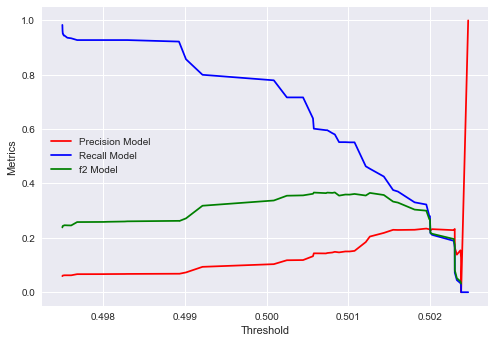

F2 score test: 0.36
Area under the ROC curve test: 0.8
Recall test: 0.55


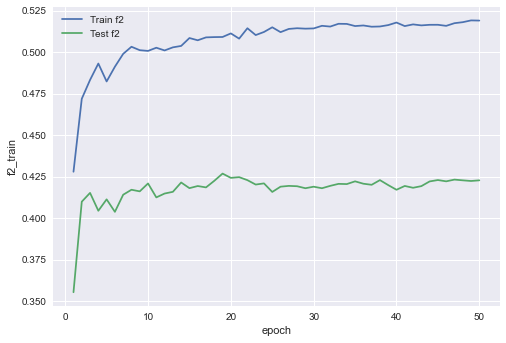

In [24]:
model = grid_search.best_estimator_

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]
# Evaluate model
eval_model(y_test, y_pred, y_proba)
_, threshold = plot_pr_curve(y_test, y_proba)
# Adjust model
y_pred_t = predict_threshold(y_proba, threshold)
eval_model(y_test, y_pred_t, y_proba)
# Plot the training results
plotdata = pd.DataFrame({"f2_train": model.evals_result()["validation_0"]["xgb_scorer"],
                        "f2_test": model.evals_result()["validation_1"]["xgb_scorer"],
                        "epoch": list(range(1,len(model.evals_result()["validation_0"]["xgb_scorer"])+1))})
plotdata
sns.lineplot(data=plotdata, x="epoch", y="f2_train")
sns.lineplot(data=plotdata, x="epoch", y="f2_test")
plt.legend(["Train f2", "Test f2"]);

### 2.3. Naive Bayes

Splitting test and train data
Balance of split: 1.02
Shape of the train dataset: (289986, 22)
Shape of the test dataset: (126087, 22)
---------------------------------------------------
Log transform features
---------------------------------------------------
Scaling data
---------------------------------------------------
Fitting
---------------------------------------------------
Model evaluation
F2 score test (train): 0.0 ( 0.0 )
Area under the ROC curve test (train): 0.81 ( 0.84 )
Recall test (train): 0.0 ( 0.0 )


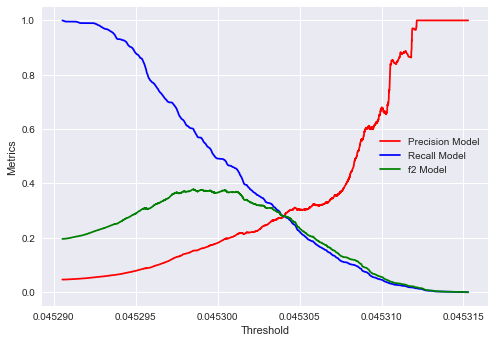

In [12]:
# Select features to include in the modeling
feats = ['smart_4_raw', 'smart_5_raw', 'smart_7_mod', 'smart_9_raw',
       'smart_12_raw', 'smart_183_raw', 'smart_184_raw', 'smart_187_raw',
       'smart_188_raw', 'smart_189_raw', 'smart_190_raw', 'smart_192_raw',
       'smart_193_raw', 'smart_194_raw', 'smart_197_raw', 'smart_198_raw',
       'smart_199_raw', 'smart_240_raw', 'smart_241_raw', 'smart_242_raw',
       'smart_999_accumulated', 'smart_999',
       'serial_number']
# Generate train and test data
X_train, X_test, y_train, y_test = create_train_data(df, feats, days=30, test_size=0.3, random_state=RSEED)
# Transform the data
X_train, X_test = log_transform(X_train+1, X_test+1)
X_train, X_test = normalize_data(X_train, X_test)
# Define the model
model_nb = GaussianNB(var_smoothing=1e+5)
# Fit and evaluate the model
model_nb, y_pred, y_proba = train_eval_model(model_nb, X_train, X_test, y_train, y_test)
_, threshold = plot_pr_curve(y_test, y_proba)

In [85]:
y_pred_t = predict_threshold(y_proba, threshold)
eval_model(y_true=y_test, y_pred=y_pred_t, y_proba=y_proba)

F2 score test: 0.38
Area under the ROC curve test: 0.81
Recall test: 0.6


### 2.4. Isolation Forest

Splitting test and train data
Balance of split: 1.02
Shape of the train dataset: (289986, 21)
Shape of the test dataset: (126087, 21)
---------------------------------------------------
F2 score test: 0.35
Area under the ROC curve test: 0.75
Recall test: 0.47


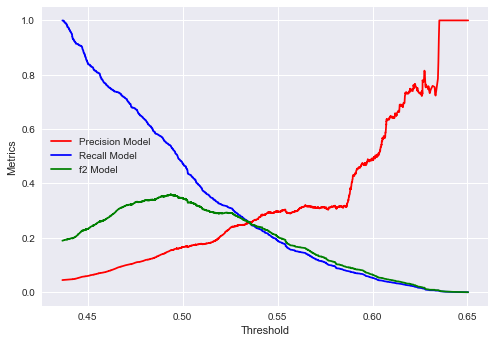

In [37]:
# Select features to include in the modeling
feats = ['smart_4_raw', 'smart_5_raw', 'smart_7_mod', 'smart_9_raw',
       'smart_12_raw', 'smart_183_raw', 'smart_184_raw', 'smart_187_raw',
       'smart_188_raw', 'smart_189_raw', 'smart_190_raw', 'smart_192_raw',
       'smart_193_raw', 'smart_194_raw', 'smart_197_raw', 'smart_198_raw',
       'smart_199_raw', 'smart_240_raw', 'smart_241_raw', 'smart_242_raw',
       'smart_999',# 'smart_999',
       'serial_number']
# Generate train and test data
X_train, X_test, y_train, y_test = create_train_data(df, feats, days=30, test_size=0.3, random_state=RSEED)
# Transform the data
# X_train, X_test = log_transform(X_train+1, X_test+1)
# X_train, X_test = normalize_data(X_train, X_test)
# Define the model
model = IsolationForest(contamination=2*(y_train.sum()/len(y_train)))
# Fit and evaluate the model
y_pred_train = -1/2*(model.fit_predict(X_train) - 1)
y_pred = -1/2*(model.predict(X_test) - 1)
y_proba = -1/2*(model.decision_function(X_test) - 1)
y_proba_train = -1/2*(model.decision_function(X_test) - 1)
eval_model(y_true=y_test, y_pred=y_pred, y_proba=y_proba)
_, threshold = plot_pr_curve(y_test, y_proba)

In [39]:
y_pred_t = predict_threshold(y_proba, threshold)
eval_model(y_true=y_test, y_pred=y_pred_t, y_proba=y_proba)

model_if = model

F2 score test: 0.36
Area under the ROC curve test: 0.75
Recall test: 0.54


### 2.5. XGBoost Regression

In [31]:
y = df.countdown
X = df.copy()[feats]
X_train, X_test, y_train, y_test = train_test_splitter(X,y,test_size=0.3,random_state=RSEED)
X_train.drop(["serial_number"], axis=1, inplace=True)
X_test.drop(["serial_number"], axis=1, inplace=True)
print(f"Balance of split: {(y_train.sum()/len(y_train))/(y_test.sum()/len(y_test)):.2f}")
print("Shape of the train dataset:", X_train.shape)
print("Shape of the test dataset:", X_test.shape)

Balance of split: 0.98
Shape of the train dataset: (289986, 21)
Shape of the test dataset: (126087, 21)


In [32]:
# Select features to include in the modeling
feats = ['smart_4_raw', 'smart_5_raw', 'smart_7_mod', 'smart_9_raw',
       'smart_12_raw', 'smart_183_raw', 'smart_184_raw', 'smart_187_raw',
       'smart_188_raw', 'smart_189_raw', 'smart_190_raw', 'smart_192_raw',
       'smart_193_raw', 'smart_194_raw', 'smart_197_raw', 'smart_198_raw',
       'smart_199_raw', 'smart_240_raw', 'smart_241_raw', 'smart_242_raw',
       'smart_999',
       'serial_number']
y = df.countdown
X = df.copy()[feats]
X_train, X_test, y_train, y_test = train_test_splitter(X,y,test_size=0.3,random_state=RSEED)
X_train.drop(["serial_number"], axis=1, inplace=True)
X_test.drop(["serial_number"], axis=1, inplace=True)
print(f"Balance of split: {(y_train.sum()/len(y_train))/(y_test.sum()/len(y_test)):.2f}")
print("Shape of the train dataset:", X_train.shape)
print("Shape of the test dataset:", X_test.shape)
# Transform the data
# X_train, X_test = log_transform(X_train+1, X_test+1)
# X_train, X_test = normalize_data(X_train, X_test)
# Define the model
model = XGBRegressor(  eval_metric="rmse", # Evaluation metric, can use our xgb_scorer
                        disable_default_eval_metric=True,
                        scale_pos_weight=len(y_train)/y_train.sum(), # ratio of number of negative class to the positive class
                        colsample_bytree=0.4, # 1, Number of features used by tree, lower to regularize
                        subsample=0.3, # 1, ratio of the training instances used, lower to regularize
                        eta=0.1, # 0.3, learning rate, lower values to regularize
                        gamma=0.2, # 0, regularization parameter, higher to regularize
                        max_depth=6, # 6, maximum tree depth
                        #n_estimators= , #
                        min_child_weight=1 , # 1, minimum sum of instance weight needed in a leaf, higher to regularize
                        #lambda=1, # L2 regularization
                        #alpha=0, # L1 regularization
                        #early_stopping_rounds = 100
                        use_label_encoder=False, verbosity=0,
                        )
# Fit and evaluate the model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
print("Evluation metrics")
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))

Balance of split: 0.98
Shape of the train dataset: (289986, 21)
Shape of the test dataset: (126087, 21)
Evluation metrics
RMSE: 175.24986647647518


### NN

In [19]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

import keras 
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout      # create layers
from keras.metrics import CategoricalAccuracy, Recall, Precision, AUC
from keras.backend import clear_session
from keras import optimizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

def create_ann_model(n_feature): # n_feature = X_train.shape[1]
    # initiate the instance
    model = Sequential()
    # layers
    model.add(Dense(units = 30, kernel_initializer = 'uniform', activation = 'relu', input_dim=n_feature))
    model.add(Dropout(0.2))
    model.add(Dense(units = 30, kernel_initializer = 'uniform', activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    # compiling the ANN
    model.compile(optimizer = 'adam', 
                  loss = 'binary_crossentropy', 
                  metrics = ['Recall', 'Precision'])
    return model

ann_classifier = KerasClassifier(build_fn=lambda: create_ann_model(n_feature = X_train.shape[1]), epochs=150, batch_size= 40000, class_weight={0 : 1.0, 1 : 10.0}, verbose=2)
ann_classifier._estimator_type = "classifier"

Epoch 1/150


2022-03-22 15:03:46.350113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 - 1s - loss: 0.9730 - recall: 0.2219 - precision: 0.1427 - 857ms/epoch - 107ms/step
Epoch 2/150
8/8 - 0s - loss: 0.9645 - recall: 0.2710 - precision: 0.2750 - 202ms/epoch - 25ms/step
Epoch 3/150
8/8 - 0s - loss: 0.9484 - recall: 0.4428 - precision: 0.2060 - 239ms/epoch - 30ms/step
Epoch 4/150
8/8 - 0s - loss: 0.9198 - recall: 0.5449 - precision: 0.1715 - 242ms/epoch - 30ms/step
Epoch 5/150
8/8 - 0s - loss: 0.8752 - recall: 0.6198 - precision: 0.1559 - 187ms/epoch - 23ms/step
Epoch 6/150
8/8 - 0s - loss: 0.8159 - recall: 0.6631 - precision: 0.1477 - 429ms/epoch - 54ms/step
Epoch 7/150
8/8 - 0s - loss: 0.7529 - recall: 0.6773 - precision: 0.1474 - 444ms/epoch - 56ms/step
Epoch 8/150
8/8 - 0s - loss: 0.7005 - recall: 0.6561 - precision: 0.1526 - 295ms/epoch - 37ms/step
Epoch 9/150
8/8 - 0s - loss: 0.6645 - recall: 0.6216 - precision: 0.1617 - 285ms/epoch - 36ms/step
Epoch 10/150
8/8 - 0s - loss: 0.6448 - recall: 0.6048 - precision: 0.1686 - 254ms/epoch - 32ms/step
Epoch 11/150
8/8 - 0

2022-03-22 15:04:17.784542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


F2 score test: 0.41
Area under the ROC curve test: 0.83
Recall test: 0.64


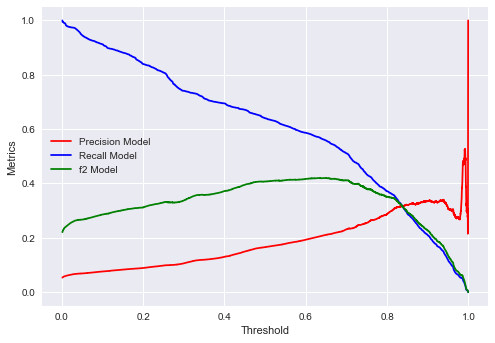

F2 score test: 0.42
Area under the ROC curve test: 0.83
Recall test: 0.57


In [32]:
ann_classifier.fit(X_train, y_train)
y_pred = ann_classifier.predict(X_test)
y_proba = ann_classifier.predict_proba(X_test)[:,1]

eval_model(y_test, y_pred, y_proba)
_, threshold = plot_pr_curve(y_test, y_proba)
# Adjust model
y_pred_t = predict_threshold(y_proba, threshold)
eval_model(y_test, y_pred_t, y_proba)

### Stacking

In [33]:
from sklearn.linear_model import LogisticRegression

# Select features to include in the modeling
feats = ['smart_4_raw', 'smart_5_raw', 'smart_7_mod', 'smart_9_raw',
       'smart_12_raw', 'smart_183_raw', 'smart_184_raw', 'smart_187_raw',
       'smart_188_raw', 'smart_189_raw', 'smart_190_raw', 'smart_192_raw',
       'smart_193_raw', 'smart_194_raw', 'smart_197_raw', 'smart_198_raw',
       'smart_199_raw', 'smart_240_raw', 'smart_241_raw', 'smart_242_raw',
       'smart_999_accumulated', 'smart_999',
       'serial_number']
# Generate train and test data
X_train, X_test, y_train, y_test = create_train_data(df, feats, days=30, test_size=0.3, random_state=RSEED)
# Transform the data
X_train, X_test = log_transform(X_train+1, X_test+1)
X_train, X_test = normalize_data(X_train, X_test)

estimators = [
    ('xgb', XGBClassifier(  disable_default_eval_metric=True,
                        validate_parameters=True,
                        objective="binary:logistic",
                        #eval_metric=xgb_scorer, # Evaluation metric, can use our xgb_scorer
                        scale_pos_weight=len(y_train)/y_train.sum(), # ratio of number of negative class to the positive class
                        colsample_bytree=0.4, # 1, Number of features used by tree, lower to regularize
                        subsample=0.3, # 1, ratio of the training instances used, lower to regularize
                        eta=0.01, # 0.3, learning rate, lower values to regularize
                        gamma=1, # 0, regularization parameter, higher to regularize
                        max_depth=6, # 6, maximum tree depth
                        n_estimators=50 , # 100, number of trees to grow
                        min_child_weight=2 , # 1, minimum sum of instance weight needed in a leaf, higher to regularize
                        reg_lambda=0.7, # 1, L2 regularization
                        reg_alpha=1, # 0, L1 regularization
                        #early_stopping_rounds = 5, #100
                        use_label_encoder=False,
                        )),
    #('nb', GaussianNB(var_smoothing=1e-11)),
    ('nn', ann_classifier),
]

clf = StackingClassifier(estimators = estimators, final_estimator=LogisticRegression(), n_jobs=-1)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

Splitting test and train data
Balance of split: 1.02
Shape of the train dataset: (289986, 22)
Shape of the test dataset: (126087, 22)
---------------------------------------------------
Log transform features
---------------------------------------------------
Scaling data
---------------------------------------------------
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Epoch 1/150


2022-03-22 15:05:19.787824: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-22 15:05:19.787932: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-03-22 15:05:19.974513: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-22 15:05:20.476143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 - 1s - loss: 0.9735 - recall: 0.3612 - precision: 0.1367 - 1s/epoch - 149ms/step
Epoch 2/150
8/8 - 0s - loss: 0.9659 - recall: 0.3816 - precision: 0.2364 - 216ms/epoch - 27ms/step
Epoch 3/150
8/8 - 0s - loss: 0.9519 - recall: 0.4985 - precision: 0.1832 - 225ms/epoch - 28ms/step
Epoch 4/150
8/8 - 0s - loss: 0.9270 - recall: 0.5902 - precision: 0.1570 - 250ms/epoch - 31ms/step
Epoch 5/150
8/8 - 0s - loss: 0.8881 - recall: 0.6517 - precision: 0.1447 - 249ms/epoch - 31ms/step
Epoch 6/150
8/8 - 0s - loss: 0.8361 - recall: 0.6835 - precision: 0.1401 - 255ms/epoch - 32ms/step
Epoch 7/150
8/8 - 0s - loss: 0.7792 - recall: 0.6760 - precision: 0.1443 - 304ms/epoch - 38ms/step
Epoch 8/150
8/8 - 0s - loss: 0.7258 - recall: 0.6419 - precision: 0.1531 - 498ms/epoch - 62ms/step
Epoch 9/150
8/8 - 1s - loss: 0.6827 - recall: 0.6146 - precision: 0.1651 - 621ms/epoch - 78ms/step
Epoch 10/150
8/8 - 0s - loss: 0.6545 - recall: 0.6009 - precision: 0.1723 - 498ms/epoch - 62ms/step
Epoch 11/150
8/8 - 0s -

2022-03-22 15:05:52.107708: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-03-22 15:05:56.452808: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-22 15:05:56.453043: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-03-22 15:05:57.276027: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150
Epoch 1/150


2022-03-22 15:06:03.163963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-22 15:06:03.198843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-22 15:06:03.225807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-22 15:06:03.305345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-22 15:06:03.324479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 - 7s - loss: 0.9740 - recall: 0.1583 - precision: 0.1492 - 7s/epoch - 1s/step
6/6 - 7s - loss: 0.9741 - recall: 0.2084 - precision: 0.1588 - 7s/epoch - 1s/step
6/6 - 7s - loss: 0.9740 - recall: 0.1985 - precision: 0.1652 - 7s/epoch - 1s/step
Epoch 2/150
Epoch 2/150
Epoch 2/150
6/6 - 7s - loss: 0.9740 - recall: 0.1720 - precision: 0.1513 - 7s/epoch - 1s/step
6/6 - 7s - loss: 0.9740 - recall: 0.1328 - precision: 0.1498 - 7s/epoch - 1s/step
Epoch 2/150
Epoch 2/150
6/6 - 1s - loss: 0.9688 - recall: 0.2816 - precision: 0.2463 - 707ms/epoch - 118ms/step
6/6 - 1s - loss: 0.9687 - recall: 0.3389 - precision: 0.2414 - 691ms/epoch - 115ms/step
6/6 - 1s - loss: 0.9689 - recall: 0.3658 - precision: 0.2473 - 690ms/epoch - 115ms/step
Epoch 3/150
Epoch 3/150
Epoch 3/150
6/6 - 1s - loss: 0.9686 - recall: 0.2634 - precision: 0.2834 - 613ms/epoch - 102ms/step
6/6 - 1s - loss: 0.9688 - recall: 0.2896 - precision: 0.2457 - 630ms/epoch - 105ms/step
Epoch 3/150
Epoch 3/150
6/6 - 1s - loss: 0.9599 - reca

2022-03-22 15:07:48.891214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 - 1s - loss: 0.5141 - recall: 0.6671 - precision: 0.2494 - 685ms/epoch - 114ms/step
Epoch 149/150
6/6 - 1s - loss: 0.5051 - recall: 0.6874 - precision: 0.2629 - 695ms/epoch - 116ms/step
Epoch 149/150
6/6 - 1s - loss: 0.5214 - recall: 0.6269 - precision: 0.2408 - 752ms/epoch - 125ms/step
Epoch 150/150
6/6 - 1s - loss: 0.5088 - recall: 0.6891 - precision: 0.2489 - 785ms/epoch - 131ms/step
Epoch 149/150
6/6 - 1s - loss: 0.5124 - recall: 0.6730 - precision: 0.2525 - 752ms/epoch - 125ms/step
Epoch 150/150
6/6 - 1s - loss: 0.5048 - recall: 0.6884 - precision: 0.2643 - 802ms/epoch - 134ms/step
Epoch 150/150
6/6 - 1s - loss: 0.5177 - recall: 0.6313 - precision: 0.2452 - 763ms/epoch - 127ms/step
6/6 - 1s - loss: 0.5108 - recall: 0.6848 - precision: 0.2439 - 744ms/epoch - 124ms/step
Epoch 150/150


2022-03-22 15:07:50.371424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 - 1s - loss: 0.5127 - recall: 0.6666 - precision: 0.2529 - 669ms/epoch - 112ms/step
6/6 - 1s - loss: 0.5059 - recall: 0.6840 - precision: 0.2637 - 640ms/epoch - 107ms/step
6/6 - 1s - loss: 0.5110 - recall: 0.6902 - precision: 0.2458 - 610ms/epoch - 102ms/step


2022-03-22 15:07:50.900659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-22 15:07:50.962383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-22 15:07:50.996219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-22 15:08:01.354906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


F2 score test: 0.0
Area under the ROC curve test: 0.83
Recall test: 0.0


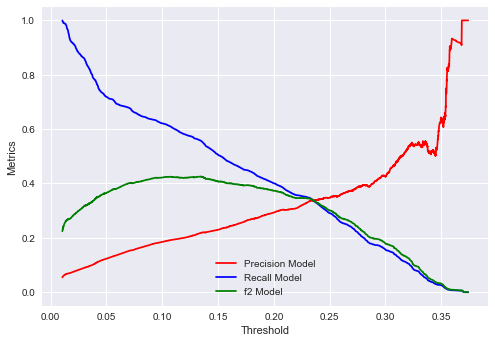

F2 score test: 0.43
Area under the ROC curve test: 0.83
Recall test: 0.56


In [34]:
eval_model(y_test, y_pred, y_proba)
_, threshold = plot_pr_curve(y_test, y_proba)
# Adjust model
y_pred_t = predict_threshold(y_proba, threshold)
eval_model(y_test, y_pred_t, y_proba)

## 3. Error analysis

For classification

Calculate countdown for test data

In [88]:
y = df.countdown
X = df.copy()[feats]
_, _, _, countdown_test = train_test_splitter(X,y,test_size=0.3,random_state=RSEED)
countdown_test = countdown_test.values

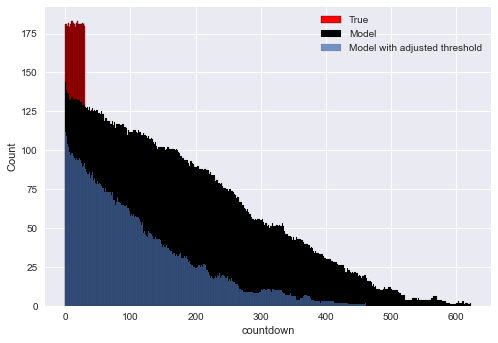

In [110]:
plotdata = pd.DataFrame({"countdown": countdown_test, "y_pred": y_pred, "y_proba": y_proba}).query("y_pred == True")
plotdata_t = pd.DataFrame({"countdown": countdown_test, "y_pred": y_pred_t, "y_proba": y_proba}).query("y_pred == True")
plotdata_test = pd.DataFrame({"y_pred": y_test, "countdown": countdown_test}).query("y_pred == 1")
sns.histplot(data=plotdata_test, x="countdown", bins=int(plotdata_test.max().countdown)+1, color='r', alpha=1)
sns.histplot(data=plotdata[["y_pred", "countdown"]], x="countdown", bins=int(plotdata.max().countdown), color='k', alpha=1)
sns.histplot(data=plotdata_t[["y_pred", "countdown"]], x="countdown", bins=int(plotdata_t.max().countdown))
plt.legend(["True", "Model", "Model with adjusted threshold"]);

Text(0.5, 0, 'Predicted Probability')

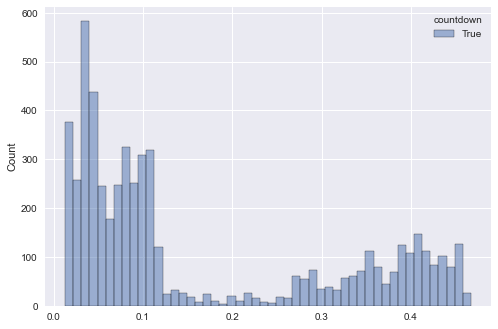

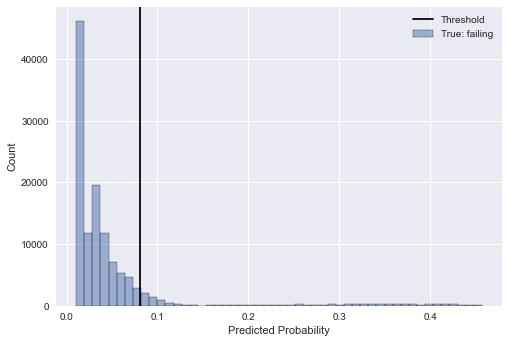

In [136]:
sns.histplot(x=y_proba[y_test == 1], hue=y_test[y_test == 1], bins=50)
plt.figure()
sns.histplot(x=y_proba[y_test == 0], hue=y_test[y_test == 0], bins=50)
#sns.histplot(x=y_proba, hue=y_test, stat="density", common_norm=False, alpha=0.4)
plt.axvline(x=threshold, c='k')
plt.legend(["Threshold", "True: failing", "True: not failing"])
plt.xlabel("Predicted Probability")

In [138]:
sum(y_test) / len(y_test)

0.04451688120107545

# Dashboard

In [140]:
date = pd.to_datetime("2021-10-25")
df[df.date == date]

,date,serial_number,model,failure,smart_1_raw,smart_4_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_12_raw,...,smart_187_raw_trigger,smart_188_raw_trigger,smart_189_raw_trigger,smart_193_raw_trigger,smart_192_raw_trigger,smart_197_raw_trigger,smart_198_raw_trigger,smart_199_raw_trigger,smart_999,smart_999_accumulated
9813,2021-10-25,Z30270W2,ST4000DM000,0,119649976.0,12.0,0.0,295857942.0,54096.0,12.0,...,False,False,False,False,False,False,False,False,0,312
16417,2021-10-25,Z302S7W9,ST4000DM000,0,81844472.0,16.0,0.0,370114130.0,53434.0,16.0,...,False,False,False,False,False,False,False,False,0,216
19881,2021-10-25,S301K6VJ,ST4000DM000,0,201946744.0,16.0,0.0,48211759.0,53007.0,16.0,...,False,False,False,False,False,False,False,False,0,154
20936,2021-10-25,S301NJFE,ST4000DM000,0,9085760.0,12.0,0.0,43872746.0,52029.0,12.0,...,False,False,False,False,False,False,False,False,0,14
22911,2021-10-25,Z3053J84,ST4000DM000,0,25054840.0,8.0,3072.0,923806818.0,50660.0,8.0,...,False,False,False,False,False,False,False,False,0,370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368231,2021-10-25,Z305HH6Z,ST4000DM000,0,28901856.0,16.0,0.0,634386808.0,46281.0,16.0,...,False,False,False,False,False,False,False,False,2,139
373874,2021-10-25,Z305DBAB,ST4000DM000,0,141160728.0,14.0,0.0,788170944.0,49842.0,14.0,...,False,False,False,False,False,False,False,False,0,60
380755,2021-10-25,S301K1XZ,ST4000DM000,0,14326264.0,19.0,0.0,780777042.0,52498.0,19.0,...,False,False,False,False,False,False,False,False,1,156
383660,2021-10-25,Z305KWSZ,ST4000DM000,0,206263208.0,3.0,0.0,681947081.0,49207.0,3.0,...,False,False,False,False,False,False,False,False,0,38


In [147]:
X=df.copy()
y=X.pop("date")

_, _, _, y_plot = train_test_splitter(X,y,test_size=0.3,random_state=RSEED)

X_test[y_plot.date == date]


AttributeError: 'Series' object has no attribute 'date'

In [149]:
X

,serial_number,model,failure,smart_1_raw,smart_4_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_12_raw,smart_183_raw,...,smart_187_raw_trigger,smart_188_raw_trigger,smart_189_raw_trigger,smart_193_raw_trigger,smart_192_raw_trigger,smart_197_raw_trigger,smart_198_raw_trigger,smart_199_raw_trigger,smart_999,smart_999_accumulated
0,Z304JG86,ST4000DM000,0,168829568.0,10.0,0.0,257899631.0,27368.0,10.0,0.0,...,False,False,False,False,False,False,False,False,0,0
1,Z304JG86,ST4000DM000,0,50913560.0,10.0,0.0,259688596.0,27392.0,10.0,0.0,...,False,False,False,False,False,False,False,False,0,0
2,Z304JG86,ST4000DM000,0,176805800.0,10.0,0.0,261018343.0,27416.0,10.0,0.0,...,False,False,False,False,False,False,False,False,0,0
3,Z304JG86,ST4000DM000,0,217666344.0,10.0,0.0,261751900.0,27440.0,10.0,0.0,...,False,False,False,False,False,False,False,False,0,0
4,Z304JG86,ST4000DM000,0,218092400.0,10.0,0.0,263166092.0,27464.0,10.0,0.0,...,False,False,False,False,False,False,False,False,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462890,Z302A12A,ST4000DM000,0,51786736.0,12.0,0.0,605732528.0,44791.0,12.0,0.0,...,False,False,False,False,False,False,False,False,0,4
462891,Z302A12A,ST4000DM000,0,63583616.0,12.0,0.0,607741466.0,44814.0,12.0,0.0,...,False,False,False,False,False,False,False,False,0,4
462892,Z302A12A,ST4000DM000,0,240597632.0,12.0,0.0,609648509.0,44838.0,12.0,0.0,...,False,False,False,False,False,False,False,False,0,4
462893,Z302A12A,ST4000DM000,1,221509184.0,12.0,0.0,611079344.0,44863.0,12.0,0.0,...,False,False,False,False,False,False,False,False,0,4


In [14]:
from mlflow.sklearn import save_model

path = "../models/final"
save_model(sk_model=clf, path=path)